## 给定数据集下的股价预测

In [1]:
from __future__ import division
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import neighbors

### 读入数据

大概了解数据构成

In [2]:
data = pd.read_csv("HFT_XY_unselected.csv")
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X325,X326,X327,X328,X329,X330,X331,X332,realY,predictY
0,0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.0,4.506952,...,4.139076,3.443876,6.085272,4.589867,-2.979077,-6.393372,-4.417067,-4.611922,-0.000000,0.0
1,1,-0.0,-0.0,-0.0,0.551516,1.103168,-0.0,-0.949546,-0.0,-0.000000,...,4.151743,4.566135,6.904618,3.911805,-4.863125,-9.709144,-3.535746,-3.946805,1.199756,0.0
2,2,-0.0,-0.0,-0.0,0.874133,0.753029,-0.0,-0.000000,-0.0,-0.000000,...,4.139076,4.062686,8.037572,4.589867,-3.737310,-7.461474,-4.846605,-5.060409,-0.516707,0.0
3,3,-0.0,-0.0,-0.0,-0.874133,0.475108,-0.0,-0.000000,-0.0,-0.000000,...,4.139076,4.031714,7.738847,4.589867,-3.202318,-8.799307,-3.505467,-4.390713,-0.000000,0.0
4,4,-0.0,-0.0,-0.0,-0.874133,1.333798,-0.0,-0.000000,-0.0,-0.000000,...,4.151743,3.638764,6.904618,3.911805,-4.063161,-9.709144,-4.418497,-4.613416,1.033414,0.0


### 画出响应变量y的分布

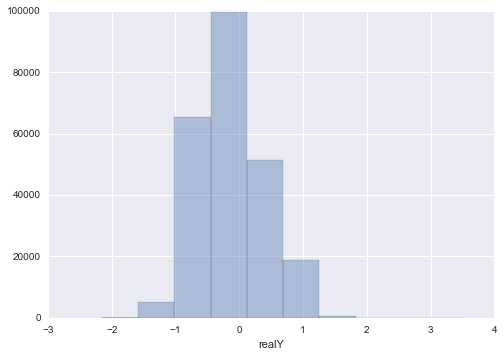

In [3]:
sns.distplot(data["realY"],bins =10,kde=False)

数据量充分，可以将数据分为训练集,CV集，测试集 7:2:1

In [3]:
x = data[data.columns[1:-2]]
y = data[data.columns[-2]]
x_train = x[:168722]
y_train = y[:168722]

x_cv = x[167822:216028]
y_cv = y[167822:216028]

X_train = x[:216028]
Y_train = y[:216028]

x_test = x[216028:]
y_test = y[216028:]

### 数据降维

In [5]:
components = [10,20,30,40,50]
for num in components:
    print "n_components is " + str(num)
    explain_variance = 0
    pca = PCA(n_components = num)
    x_train_1 = pca.fit_transform(x_train)
    explain_variance = sum(pca.explained_variance_ratio_)
    print "total explain variance ratio is "+ str(explain_variance)
        

n_components is 10
total explain variance ratio is 0.509762710039
n_components is 20
total explain variance ratio is 0.694931599358
n_components is 30
total explain variance ratio is 0.796574223926
n_components is 40
total explain variance ratio is 0.85734969391
n_components is 50
total explain variance ratio is 0.895858907766


从上面输出结果可以看出当将训练数据降至50维时，可被解释的方差达到原方差的近90%，所以我们选择将数据降至50维。

In [4]:
pca = PCA(n_components = 50)
x_train = pca.fit_transform(x_train)
X_train = pca.transform(X_train)
x_cv = pca.transform(x_cv)
x_test = pca.transform(x_test)

tsne电脑跑不起来，所以就没有用

# 数据拟合

## KNN

In [11]:
# 通过CV集挑出neighbor的个数
neighbors_list = range(200,550,50)
result = 0
n_list = []
for n in neighbors_list:
    print "The numbers of neighbors are " + str(n)
    knn = neighbors.KNeighborsRegressor(n_neighbors = n)
    knn.fit(x_train,y_train)
    scoring = knn.score(x_cv,y_cv)
    print "Scores are " + str(scoring)
    y_pre = knn.predict(x_cv)
    if scoring > result:
        result = scoring
        n_list.append(n)


The numbers of neighbors are 200
Scores are 0.0350515465345
The numbers of neighbors are 250
Scores are 0.0350290941555
The numbers of neighbors are 300
Scores are 0.0353346963466
The numbers of neighbors are 350
Scores are 0.0356945950601
The numbers of neighbors are 400
Scores are 0.0359832484937
The numbers of neighbors are 450
Scores are 0.0361659456919
The numbers of neighbors are 500
Scores are 0.0363699521198


跑出来效果不是很好，将neighbor的个数提升再看看效果

In [13]:
neighbors_list = range(600,2000,200)
result = 0
n_list = []
for n in neighbors_list:
    print "The numbers of neighbors are " + str(n)
    knn = neighbors.KNeighborsRegressor(n_neighbors = n)
    knn.fit(x_train,y_train)
    scoring = knn.score(x_cv,y_cv)
    print "Scores are " + str(scoring)
    y_pre = knn.predict(x_cv)
    if scoring > result:
        result = scoring
        n_list.append(n)

The numbers of neighbors are 600
Scores are 0.0364656920693
The numbers of neighbors are 800
Scores are 0.0365776920053
The numbers of neighbors are 1000
Scores are 0.036339532912
The numbers of neighbors are 1200
Scores are 0.0359596368326
The numbers of neighbors are 1400
Scores are 0.035870665422
The numbers of neighbors are 1600
Scores are 0.0357021283032
The numbers of neighbors are 1800
Scores are 0.0354952667126


可以看出当 the number of neighbors 从1000往后，Scores反而下降。所以我们选择the number of neighbors为800，用训练集和CV集数据合起来训练模型，将其在test集上的score作为基准值。

In [6]:
best_n = 800
knn = neighbors.KNeighborsRegressor(n_neighbors = best_n)
# 用训练集+CV集的数据来拟合模型
knn.fit(X_train,Y_train)
benchmark = knn.score(x_test,y_test)
print benchmark

0.044611046151


## GBDT

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

用CV集选出最好的参数，这里只选择部分参数，否则运行时间实在太长。

In [6]:
tuned_parameters = [{'n_estimators':range(50,500,50),'max_depth': range(1,10), 'max_features': range(1,10)}]
gbdt = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits = 5)
clf = GridSearchCV(gbdt, tuned_parameters, cv = tscv,n_jobs = -1)
clf.fit(X_train, Y_train)
print "Best parameters set found on development set:"
print clf.best_params_


Best parameters set found on development set:
{'max_features': 8, 'n_estimators': 450, 'max_depth': 2}


用全部的训练数据作训练，得出测试集上的$R^2$，可以看出gbdt比knn还是有不少提升。

In [12]:
perfect_gbdt = GradientBoostingRegressor(max_features = 8, n_estimators = 450, max_depth = 2)
perfect_gbdt.fit(X_train,Y_train)
perfect_gbdt.score(x_test,y_test)

0.058392871307317733

## Ensemble

接下来考虑用集成学习，将一些模型组合起来。

### Hard voting in Regression(Average)

In [ ]:
from sklearn import svm
from sklearn.metrics import r2_score

gbdt = GradientBoostingRegressor(max_features = 8, n_estimators = 450, max_depth = 2)
knn = neighbors.KNeighborsRegressor(n_neighbors = best_n)
svr = svm.SVR()

gbdt.fit(X_train,Y_train)
knn.fit(X_train,Y_train)
svr.fit(X_train,Y_train)

gbdt_pre = gbdt.predict(x_test)
knn_pre = knn.predict(x_test)
svr_pre = svr.predict(x_test)

y_pre = (gbdt_pre + knn_pre + svr_pre)/3
r2 = r2_score(y_test,y_pre)
print "Hard average result is " + str(r2)

In [15]:
import sklearn.metrics as sm

In [17]:
sm.r2_score?

In [19]:
a = 2
print "Hard average result is" + str(a)

Hard average result is2
